In [2]:
# To do

# Grid search
#   - Signal sweep
#   - Parameter sweep
# Other assets
# 

In [63]:
import numpy as np
import yfinance as yf
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import datetime


import arch.bootstrap as ab

In [4]:
START = "2015-01-01"
END = "2025-01-01"
TICKER = "^GSPC"
TITLE = TICKER + " - " + (datetime.now()).strftime("%Y-%m-%d - %H:%M:%S")

In [5]:
# data = yf.download("^GSPC",start=START, end=END,multi_level_index=False)
# data.to_csv("data2.csv")

In [6]:
data = pd.read_csv("data2.csv", index_col=0, parse_dates=True)

# data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))
#
# data.dropna(inplace=True)

In [7]:
data = data.drop(columns=["High", "Low", "Open", "Volume"])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-01-02 to 2024-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [9]:
def tenkan(data, t=9):
    return (((data.rolling(t).max()) + (data.rolling(t).min())) / 2).rename("tenkan")


def kijin(data, t=26):
    return (((data.rolling(t).max()) + (data.rolling(t).min())) / 2).rename("kijin")


def chikou(data, t=26):
    return (data.shift(-t)).rename("chikou")


def span_a(data, t_short=9, t_mid=26):
    return ((((tenkan(data, t_short) + kijin(data, t_mid))) / 2).shift(t_mid)).rename("span_a")


def span_b(data, t_mid=26, t_long=52):
    return ((((data.rolling(t_long).max()) + (data.rolling(t_long).min())) / 2).shift(t_mid)).rename("span_b")

In [10]:
def apply_ichi(data, short=9, medium=26, long=52):
    """
    data : pandas.core.series.Series

    returns : pandas.core.frame.DataFrame
    """
    if not isinstance(data, pd.Series):
        raise TypeError(f"input data must be {pd.Series}")


    data = data.copy()
    _tenkan = tenkan(data, short)

    _kijin = kijin(data, medium)
    _chikou = chikou(data, medium)
    _span_a = span_a(data, short, medium)

    _span_b = span_b(data, medium, long)


    return pd.concat([data, _tenkan, _kijin, _chikou, _span_a, _span_b], axis=1)

In [11]:
returns = (np.log(data["Close"] / data["Close"].shift(1)).dropna())

# apply_ichi(returns.cumsum()).plot()

# ichi = apply_ichi(returns.cumsum())
# ichi

# Signals

In [12]:
# Bullish patterns

def l_1(data):
    return data["tenkan"] > data["kijin"]


def l_2(data):
    return data["chikou"] > data["Close"]


def l_3(data):
    # Check span a and span b offsets
    return data["Close"] > np.max([data["span_a"], data["span_b"]], axis=0)

# Bearish patterns

def s_1(data):
    return data["tenkan"] < data["kijin"]


def s_2(data):
    return data["chikou"] < data["Close"]


def s_3(data):
    # Check span a and span b offsets
    return data["Close"] < np.min([data["span_a"], data["span_b"]], axis=0)

In [13]:
bullish_signals = [l_1, l_2, l_3]
bearish_signals = [s_1, s_2, s_3]

<Axes: >

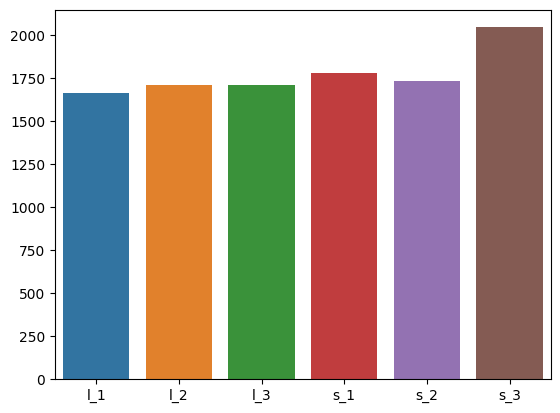

In [14]:
sns.barplot(pd.DataFrame([{signal.__name__: signal(apply_ichi(data["Close"])).value_counts().iloc[0]} for signal in bullish_signals + bearish_signals]))

# Entry

In [15]:
def en_l_1(data):
    return l_1(data) & (data["Close"] > data["kijin"])


def en_l_2(data):
    return l_2(data) & (data["Close"] > data["kijin"])


def en_l_12(data):
    return l_1(data) & l_2(data) & (data["Close"] > data["kijin"])


def en_l_123(data):
    return l_1(data) & l_2(data) & l_3(data) & (data["Close"] > data["kijin"])


def en_s_1(data):
    return s_1(data) & (data["Close"] < data["kijin"])


def en_s_2(data):
    return s_2(data) & (data["Close"] < data["kijin"])


def en_s_12(data):
    return s_1(data) & s_2(data) & (data["Close"] < data["kijin"])


def en_s_123(data):
    return s_1(data) & s_2(data) & s_3(data) & (data["Close"] < data["kijin"])

In [16]:
entry_signals_bull = [en_l_1, en_l_2, en_l_12, en_l_123]

entry_signals_bear = [en_s_1, en_s_2, en_s_12, en_s_123]

<Axes: >

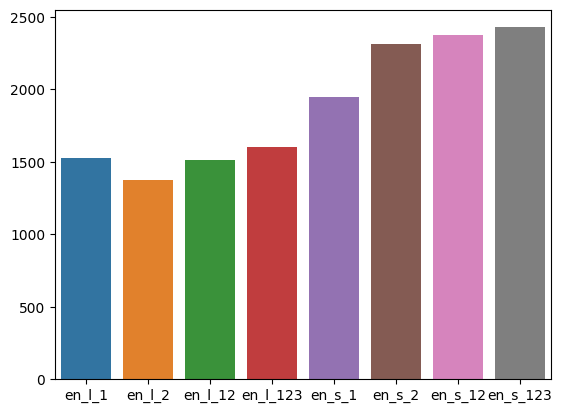

In [17]:
sns.barplot(pd.DataFrame(
    [{x.__name__: x(apply_ichi(data["Close"])).value_counts().iloc[0]} for x in entry_signals_bull + entry_signals_bear]))

# Exit

In [18]:
def ex_l_1(data):
    return data["Close"] < data["kijin"]


def ex_l_2(data):
    # TK(t) < KJ(t)
    return s_1(data)


def ex_l_3(data):
    # CK(t) < P_L(t-25)
    return s_2(data)


def ex_l_4(data):
    # TK(t) < KJ(t) & (CK(t) < P L(t − 25))
    return s_1(data) & s_2(data)


def ex_l_5(data):
    # (TK(t) < KJ(t)) & (CK(t) < P L(t − 25)) & P c(t) < min{SKA(t − 25), SKB(t − 25)}
    return s_1(data) & s_2(data) & s_3(data)


# !!! WIP !!!
def ex_s_1(data):
    return data["Close"] > data["kijin"]


def ex_s_2(data):
    return l_2(data) & (data["Close"] > data["kijin"])


def ex_s_3(data):
    return l_1(data) & l_2(data) & (data["Close"] > data["kijin"])


def ex_s_4(data):
    return l_1(data) & l_2(data) & l_3(data) & (data["Close"] > data["kijin"])


def ex_s_5(data):
    return s_1(data) & (data["Close"] < data["kijin"])



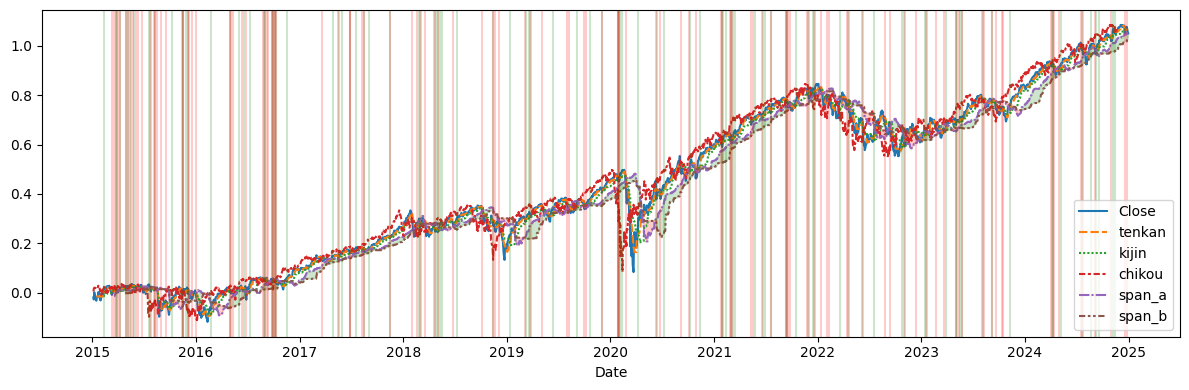

In [19]:
plt.figure(figsize=(12, 4))

ichi_data = apply_ichi(returns.cumsum())

data_here = ichi_data[:]

ax = sns.lineplot(data=data_here)

signal = en_l_1

mask = (signal(data_here).dropna() == 1) & (signal(data_here).dropna().shift(1) == 0)

for index, value in mask.items():
    if value:
        ax.axvline(index, alpha=0.2, color="green")

signal = ex_l_1

mask = (signal(data_here).dropna() == 1) & (signal(data_here).dropna().shift(1) == 0)


for index, value in mask.items():
    if value:
        ax.axvline(index, alpha=0.2, color="red")

ax.fill_between(data_here.index, data_here["span_a"], data_here["span_b"], where=data_here["span_a"] > data_here["span_b"], color="green", alpha=0.2)
ax.fill_between(data_here.index, data_here["span_a"], data_here["span_b"], where=data_here["span_a"] < data_here["span_b"], color="red", alpha=0.2)

plt.tight_layout()

plt.show()

# Trading Ichimoku

In [20]:
ichi_data = apply_ichi(returns.cumsum())

trading_data = pd.DataFrame(index=pd.DatetimeIndex(ichi_data.index))

strategies_l = [[ex_l_1,[en_l_1, en_l_2, en_l_12, en_l_123]], [ex_l_2, [en_l_1, en_l_12, en_l_123]], [ex_l_3, [en_l_2, en_l_12, en_l_123]], [ex_l_4, [en_l_12, en_l_123]], [ex_l_5, [en_l_123]]]
strategies_s = [[ex_s_1,[en_s_1, en_s_2, en_s_12, en_s_123]], [ex_s_2, [en_s_1, en_s_12, en_s_123]], [ex_s_3, [en_s_2, en_s_12, en_s_123]], [ex_s_4, [en_s_12, en_s_123]], [ex_s_5, [en_s_123]]]

count = 0
for exit, entry_list in strategies_l + strategies_s:
    print(exit.__name__)
    for entry in entry_list:
        print(f"    {entry.__name__}")
        count += 1

print(f"{count=}")

ex_l_1
    en_l_1
    en_l_2
    en_l_12
    en_l_123
ex_l_2
    en_l_1
    en_l_12
    en_l_123
ex_l_3
    en_l_2
    en_l_12
    en_l_123
ex_l_4
    en_l_12
    en_l_123
ex_l_5
    en_l_123
ex_s_1
    en_s_1
    en_s_2
    en_s_12
    en_s_123
ex_s_2
    en_s_1
    en_s_12
    en_s_123
ex_s_3
    en_s_2
    en_s_12
    en_s_123
ex_s_4
    en_s_12
    en_s_123
ex_s_5
    en_s_123
count=26


In [22]:
def trade(data, entry, exit, short=9, medium=26, long=52):
    """
    data = log returns of closing prices using pandas series.
    entry and exit are functions. 
    """

    ichi_data = apply_ichi(data, short, medium, long)

    # Apply entry and exit signals
    mask_1 = (entry(ichi_data).dropna() == 1) & (entry(ichi_data).dropna().shift(1) == 0)
    mask_2 = (exit(ichi_data).dropna() == 1) & (exit(ichi_data).dropna().shift(1) == 0)

    df = pd.concat([mask_1, mask_2, pd.Series(np.zeros(mask_1.shape), index=mask_1.index)], axis=1)
    df.columns = ["col1", "col2", "col3"] 

    buy_state = 0
    col3_values = []

    # Iterate
    for index, row in df.iterrows():
        col3_values.append(buy_state)
        if row['col1']:
            buy_state = 1
        elif row['col2']:
            buy_state = 0

    df['col3'] = col3_values
    performance = (data * df["col3"])

    return performance

df = trade(returns, en_l_1, ex_l_3)
print(df)
# ichi_data["Close"]

Date
2015-01-05   -0.000000
2015-01-06   -0.000000
2015-01-07    0.000000
2015-01-08    0.000000
2015-01-09   -0.000000
                ...   
2024-12-24    0.010982
2024-12-26   -0.000406
2024-12-27   -0.011117
2024-12-30   -0.010760
2024-12-31   -0.004294
Length: 2515, dtype: float64


In [88]:
def sharpe_ratio(data, entry, exit, short=9, medium=26, long=52):
    x = trade(data, entry, exit, short, medium, long)
    mu, sigma = 12 * x.mean(), np.sqrt(12 * x.var())
    values = np.array([mu, sigma, mu / sigma]).squeeze()
    index = ["mu", "sigma", "Sharpe"]
    return pd.Series(values, index=index)

In [23]:
columns = []
for strategy in strategies_l:
    ex = strategy[0]
    en_list = strategy[1]
    for en in en_list:
        columns.append((ex, en))

multi_index = pd.MultiIndex.from_tuples(columns)
trading_data = pd.DataFrame(columns=multi_index)

for exit, entry_list in strategies_l:
    for entry in entry_list:
        # print(f"{exit.__name__} - {e.__name__}")
        out = (trade(returns.cumsum(),entry,exit))
        # print(exit)
        trading_data[(exit, entry)] = out

trading_data

<function ex_l_1 at 0x00000265277398A0>  \
           <function en_l_1 at 0x000002652764BBA0>   
Date                                                 
2015-01-05                                    -0.0   
2015-01-06                                    -0.0   
2015-01-07                                    -0.0   
2015-01-08                                     0.0   
2015-01-09                                    -0.0   
...                                            ...   
2024-12-24                                     0.0   
2024-12-26                                     0.0   
2024-12-27                                     0.0   
2024-12-30                                     0.0   
2024-12-31                                     0.0   

                                                    \
           <function en_l_2 at 0x000002652764BD80>   
Date                                                 
2015-01-05                                    -0.0   
2015-01-06                                    -0.0   
2015-01-07                                    -0.0   
2015-01-08                                     0.0   
2015-01-09                                    -0.0   
...                                            ...   
2024-12-24                                     0.0   
2024-12-26                                     0.0   
2024-12-27                                     0.0   
2024-12-30                                     0.0   
2024-12-31                                     0.0   

                                                     \
           <function en_l_12 at 0x000002652764BCE0>   
Date                                                  
2015-01-05                                     -0.0   
2015-01-06                                     -0.0   
2015-01-07                                     -0.0   
2015-01-08                                      0.0   
2015-01-09                                     -0.0   
...                                             ...   
2024-12-24                                      0.0   
2024-12-26                                      0.0   
2024-12-27                                      0.0   
2024-12-30                                      0.0   
2024-12-31                                      0.0   

                                                      \
           <function en_l_123 at 0x000002652764BEC0>   
Date                                                   
2015-01-05                                      -0.0   
2015-01-06                                      -0.0   
2015-01-07                                      -0.0   
2015-01-08                                       0.0   
2015-01-09                                      -0.0   
...                                              ...   
2024-12-24                                       0.0   
2024-12-26                                       0.0   
2024-12-27                                       0.0   
2024-12-30                                       0.0   
2024-12-31                                       0.0   

           <function ex_l_2 at 0x0000026527739BC0>  \
           <function en_l_1 at 0x000002652764BBA0>   
Date                                                 
2015-01-05                                    -0.0   
2015-01-06                                    -0.0   
2015-01-07                                    -0.0   
2015-01-08                                     0.0   
2015-01-09                                    -0.0   
...                                            ...   
2024-12-24                                     0.0   
2024-12-26                                     0.0   
2024-12-27                                     0.0   
2024-12-30                                     0.0   
2024-12-31                                     0.0   

                                                     \
           <function en_l_12 at 0x000002652764BCE0>   
Date                                                  
2015-01-05         

# Bootstrapping

In [24]:
returns = np.log(data["Close"] / data["Close"].shift(1)).dropna()

In [26]:
block_length = ab.optimal_block_length(returns ** 2)["stationary"].iloc[0]

In [27]:
bs = ab.StationaryBootstrap(block_length, returns, seed=44)

In [40]:
results = bs.apply(sharpe_ratio, 1000, {"entry":en_l_1, "exit":ex_l_1})
# run time - 2500 - 2m 58s

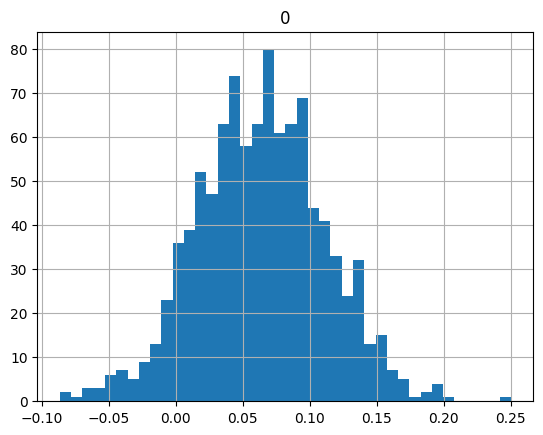

In [41]:
sr = pd.DataFrame(results[:, -1:])

fig = sr.hist(bins=40)

In [ ]:
cov = bs.cov(sharpe_ratio, 1000, extra_kwargs={"entry":en_l_1, "exit":ex_l_1})
# run time 2025/05/18 15:07 - 1000 - 1m 16s
# run time 2025/05/18 15:09 - 1000 - 1m 16s

In [90]:
ci = bs.conf_int(sharpe_ratio, 100, method="basic", extra_kwargs={"entry":en_l_1, "exit":ex_l_1})
# run time 100      -      7.4s
# run time 1_000    -  1m 16.6s
# run time 10_000   - 11m 46.7s
    

In [91]:
ci = pd.DataFrame(ci, index=["Lower", "Upper"], columns=["mu", "sigma", "Sharpe"])
print(ci)

             mu     sigma    Sharpe
Lower -0.000278  0.013895 -0.011364
Upper  0.002727  0.020914  0.157288


# CI for sharpe

In [94]:

# Initialisation
columns = []
for strategy in strategies_l:
    ex = strategy[0]
    en_list = strategy[1]
    for en in en_list:
        for measure in ["mu", "sigma", "Sharpe"]:
            columns.append((ex, en, measure))

multi_index = pd.MultiIndex.from_tuples(columns)
trading_ci = pd.DataFrame(columns=multi_index, index=["Lower", "Upper"])
count = 0

# Tests
for exit, entry_list in strategies_l:
    for entry in entry_list:
        print(f"{datetime.datetime.now().strftime("%H:%M:%S")} : {exit.__name__} - {entry.__name__} - {count=}")
        out = (bs.conf_int(sharpe_ratio, 1_000, extra_kwargs={"entry":entry, "exit":exit}))
        # print(exit)
        trading_ci[(exit, entry)] = out
        count += 1

trading_ci

# 1000 = 15m 36.5s

10:40:51 : ex_l_1 - en_l_1 - count=0
10:42:02 : ex_l_1 - en_l_2 - count=1
10:43:14 : ex_l_1 - en_l_12 - count=2
10:44:26 : ex_l_1 - en_l_123 - count=3
10:45:40 : ex_l_2 - en_l_1 - count=4
10:46:52 : ex_l_2 - en_l_12 - count=5
10:48:03 : ex_l_2 - en_l_123 - count=6
10:49:15 : ex_l_3 - en_l_2 - count=7
10:50:27 : ex_l_3 - en_l_12 - count=8
10:51:39 : ex_l_3 - en_l_123 - count=9
10:52:51 : ex_l_4 - en_l_12 - count=10
10:54:02 : ex_l_4 - en_l_123 - count=11
10:55:15 : ex_l_5 - en_l_123 - count=12


<function ex_l_1 at 0x00000265277398A0>                      \
      <function en_l_1 at 0x000002652764BBA0>                       
                                           mu     sigma    Sharpe   
Lower                               -0.000493  0.013532 -0.023781   
Upper                                0.002891  0.020796  0.168963   

                                                                   \
      <function en_l_2 at 0x000002652764BD80>                       
                                           mu     sigma    Sharpe   
Lower                               -0.002380  0.015382 -0.133270   
Upper                                0.001515  0.022501  0.074877   

                                                                    \
      <function en_l_12 at 0x000002652764BCE0>                       
                                            mu     sigma    Sharpe   
Lower                                -0.000907  0.010367 -0.071233   
Upper                                 0.001942  0.016585  0.151506   

                                                 ...  \
      <function en_l_123 at 0x000002652764BEC0>  ...   
                                             mu  ...   
Lower                                 -0.001363  ...   
Upper                                  0.000820  ...   

        <function ex_l_3 at 0x0000026527739E40>  \
      <function en_l_123 at 0x000002652764BEC0>   
                                         Sharpe   
Lower                                 -0.172456   
Upper                                  0.141627   

       <function ex_l_4 at 0x0000026527739B20>                      \
      <function en_l_12 at 0x000002652764BCE0>                       
                                            mu     sigma    Sharpe   
Lower                                -0.000250  0.016164 -0.020202   
Upper                                 0.005028  0.028990  0.203043   

                                                                     \
      <function en_l_123 at 0x000002652764BEC0>                       
                                             mu     sigma    Sharpe   
Lower                                 -0.002272  0.013103 -0.125271   
Upper                                  0.002258  0.026878  0.097026   

        <function ex_l_5 at 0x0000026527739C60>                      
      <function en_l_123 at 0x000002652764BEC0>                      
                                             mu     sigma    Sharpe  
Lower                                  0.002710  0.018885  0.078057  
Upper                                  0.008681  0.032522  0.317131  

[2 rows x 39 columns]

In [95]:
trading_ci.to_csv(f"trading_confidence_intervals_{datetime.datetime.now().strftime("%d-%m-%Y, %H-%M-%S")}.csv")

In [96]:
np.any(trading_ci.loc["Lower"] > 0)

np.True_

# SPA

In [ ]:
def spa_test(data, entry, exit, alpha=0.05, verbose=False):
    """
    Benchmark is buy and hold
    
    """
    strategy_loss = -trade(data, entry, exit)

    # strategy_loss.plot()

    benchmark_loss = -data

    a = ab.SPA(benchmark_loss, strategy_loss,reps=10_000)

    a.compute()

    if verbose:
        if a.pvalues["consistent"] < alpha:
            print(f"reject null, The strategy is NOT superior to all benchmarks., p value is {a.pvalues["consistent"]}")
        else:
            print(f"fail to reject null, The strategy is not inferior to any benchmark (supports superiority), p value is {a.pvalues["consistent"]}")
            
    return a.pvalues["consistent"]

In [53]:
spa_test(returns, en_l_1, ex_l_5)

np.float64(0.1968)

<Axes: xlabel='Date'>

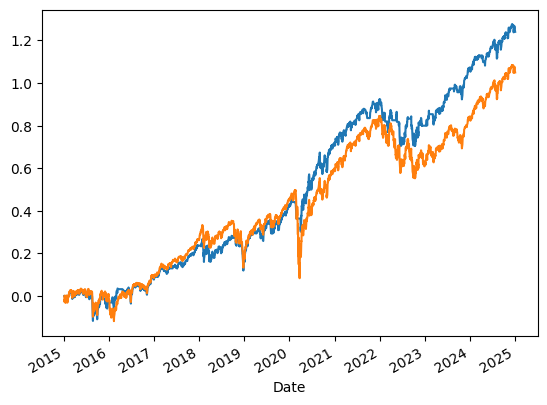

In [54]:
trade(returns, en_l_1, ex_l_5).cumsum().plot()
returns.cumsum().plot()

In [55]:
columns = []
for strategy in strategies_l:
    ex = strategy[0]
    en_list = strategy[1]
    for en in en_list:
        columns.append((ex, en))

multi_index = pd.MultiIndex.from_tuples(columns)
spa_data = pd.DataFrame(columns=multi_index)

for exit, entry_list in strategies_l:
    for entry in entry_list:
        # print(f"{exit.__name__} - {e.__name__}")
        out = [spa_test(returns, entry, exit)]
        # print(exit)
        spa_data[(exit, entry)] = out

In [56]:
print(spa_data.T)

                                                                                        0
<function ex_l_1 at 0x00000265277398A0> <function en_l_1 at 0x000002652764BBA0>    0.9809
                                        <function en_l_2 at 0x000002652764BD80>    0.5021
                                        <function en_l_12 at 0x000002652764BCE0>   0.4778
                                        <function en_l_123 at 0x000002652764BEC0>  0.4908
<function ex_l_2 at 0x0000026527739BC0> <function en_l_1 at 0x000002652764BBA0>    0.4689
                                        <function en_l_12 at 0x000002652764BCE0>   0.4918
                                        <function en_l_123 at 0x000002652764BEC0>  0.4858
<function ex_l_3 at 0x0000026527739E40> <function en_l_2 at 0x000002652764BD80>    0.4945
                                        <function en_l_12 at 0x000002652764BCE0>   0.4924
                                        <function en_l_123 at 0x000002652764BEC0>  0.4924
<function 

In [61]:
np.min(spa_data)

np.float64(0.4689)